<a href="https://colab.research.google.com/github/irisawa/fy21compe/blob/main/Classic_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT以前の手法

-  Naive Bayes
-  Logistic Regression
-  SVM
-  Random Forest
- XGBoosting

In [ ]:
!pip install sklearn --quiet
!pip install pandas --quiet

In [ ]:
# importing packages
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
%matplotlib inline

# sklearn packages
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# nltk packages
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from string import punctuation

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/data/training.tsv", delimiter='\t')
df.head()

,sid,sentence,html_id,label
0,tr-01-0000,PART I,Form10k_01,0
1,tr-01-0001,The “Business” section and other parts of this...,Form10k_01,0
2,tr-01-0002,"Statements that are not historical facts, inc...",Form10k_01,0
3,tr-01-0003,Our actual results may differ materially from...,Form10k_01,0
4,tr-01-0004,Factors that could cause such differences inc...,Form10k_01,0


In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/data/test.tsv", delimiter='\t')
test_df.head()

,sid,sentence,html_id
0,pb-09-0000,PART I,Form10k_09
1,pb-09-0001,"In this Annual Report on Form 10-K, unless oth...",Form10k_09
2,pb-09-0002,We use the term “Holding Company” to refer sol...,Form10k_09
3,pb-09-0003,Item 1.,Form10k_09
4,pb-09-0004,Business,Form10k_09


In [ ]:
minimum_num = df['label'].value_counts().min()
dfs = [d.sample(minimum_num, random_state=0) for name, d in df.groupby('label')]
under_resampled_df = pd.concat(dfs).sample(frac=1, random_state=0)
X_resampled = under_resampled_df.to_numpy()
dfx = pd.DataFrame(X_resampled)
dfx = dfx.set_axis(['sid', 'sentence', 'html_id', 'label'], axis=1)
dfx.head()

,sid,sentence,html_id,label
0,tr-60-0187,The CCPA provides for civil penalties for viol...,Form10k_60,3
1,tr-55-0457,"Further, regulation of GHG emissions may limit...",Form10k_55,1
2,tr-63-0077,Consumers increasingly demand computing device...,Form10k_63,1
3,tr-30-0815,Despite our agreement to obtain an opinion fro...,Form10k_30,0
4,tr-15-0700,"Effective January 1, 2018, the Federal Departm...",Form10k_15,1


In [ ]:
dfx.label.value_counts()

3    191
2    191
1    191
0    191
Name: label, dtype: int64

In [ ]:
def preprocess_corpus(df, column='text'):
    df[column] = df[column].apply(clean_text)
    return df

In [ ]:
def clean_text(text):
    text = text.lower()
    remove_xx_seq  = re.compile('xx+')
    replace_by_space = re.compile('[/(){}\[\]\|@,;”“]')
    remove_special_characters = re.compile('[^0-9a-z +]')
    remove_extra_space = re.compile('[^A-Za-z0-9]+')
    remove_numbers = re.compile('[0-9]+')
    text = re.sub(remove_xx_seq, ' ', text)
    text = re.sub(replace_by_space, ' ', text)
    text = re.sub(remove_special_characters, ' ', text)
    text = re.sub(remove_numbers, ' ', text)
    text = re.sub(remove_extra_space, ' ', text)
    return text.strip()

In [ ]:
print('Cleaning the text...', end='')
dfz = preprocess_corpus(dfx, column='sentence')
print('done.')

Cleaning the text...done.


In [ ]:
dfz.head()

,sid,sentence,html_id,label
0,tr-60-0187,the ccpa provides for civil penalties for viol...,Form10k_60,3
1,tr-55-0457,further regulation of ghg emissions may limit ...,Form10k_55,1
2,tr-63-0077,consumers increasingly demand computing device...,Form10k_63,1
3,tr-30-0815,despite our agreement to obtain an opinion fro...,Form10k_30,0
4,tr-15-0700,effective january the federal department of en...,Form10k_15,1


In [ ]:
def compute_tfidf(corpus, stop_words='english', ngram_range=(1, 1), max_features=None):
    vectorizer = TfidfVectorizer(input='content', stop_words=stop_words, ngram_range=ngram_range, min_df=3, max_df=0.9, max_features=max_features)
    print('Computing tfidf features...', end='')
    X = vectorizer.fit_transform(corpus)
    print('done!')
    return X, vectorizer

In [ ]:
def encode_labels(labels):
    """ Encode the class labels into a numbers. """
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(labels)
    return label_encoder

In [ ]:
from sklearn import preprocessing

stop_words    = 'english'
ngram_range   = (1, 1)
max_features  = None
X, vectorizer = compute_tfidf(dfz['sentence'], stop_words, ngram_range, max_features)

# Encode the labels
labels = dfz.label.unique()
label_encoder = encode_labels(labels)
y = label_encoder.transform(dfz.label)

Computing tfidf features...done!


In [ ]:
labels=list(map(str,labels))
labels

['3', '1', '0', '2']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print('Training set Shape: {}  | Test set Shape: {}'.format(X_train.shape, X_test.shape))

Training set Shape: (611, 1014)  | Test set Shape: (153, 1014)


In [ ]:
def train_test_model(model, X_train, X_test, y_train, y_test,labels):
    print('Start training...', end='')
    model.fit(X_train, y_train)
    print('done!')
    print('Start testing...', end='')
    predictions = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    metrics_report = classification_report(y_test, predictions, target_names=labels)
    precision, recall, fscore, train_support = score(y_test, predictions, average='weighted')
    print('done!')
    return predictions, accuracy, metrics_report, (precision, recall, fscore)

# Naive Bais

Number of documents = 611  |  Number of features = 1014
Start training...done!
Start testing...done!
Total time: 0.01s
accuracy: 0.7908496732026143
              precision    recall  f1-score   support

           3       0.79      0.61      0.69        38
           1       0.89      0.87      0.88        39
           0       0.74      0.89      0.81        38
           2       0.75      0.79      0.77        38

    accuracy                           0.79       153
   macro avg       0.79      0.79      0.79       153
weighted avg       0.79      0.79      0.79       153



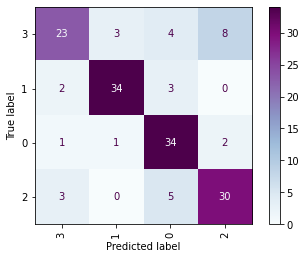

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import plot_confusion_matrix

nb_model = MultinomialNB()
print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, accuracy, metrics_report, nb_prf = train_test_model(nb_model, X_train, X_test, y_train, y_test, labels)
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('accuracy: {}'.format(accuracy))
print('='*100)
print(metrics_report)
plot_confusion_matrix(nb_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")
# plt.show()

# Logistic Regression

Number of documents = 611  |  Number of features = 1014
Start training...done!
Start testing...done!
Total time: 0.08s
accuracy: 0.803921568627451
              precision    recall  f1-score   support

           3       0.77      0.71      0.74        38
           1       1.00      0.85      0.92        39
           0       0.72      0.89      0.80        38
           2       0.76      0.76      0.76        38

    accuracy                           0.80       153
   macro avg       0.81      0.80      0.80       153
weighted avg       0.82      0.80      0.81       153



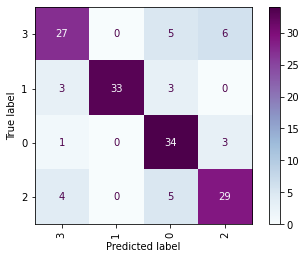

In [ ]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(penalty='l2', max_iter=500)
print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, accuracy, metrics_report, log_prf = train_test_model(log_model, X_train, X_test, y_train, y_test, labels)
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('accuracy: {}'.format(accuracy))
print('='*100)
print(metrics_report)
plot_confusion_matrix(log_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

# SVM

Number of documents = 611  |  Number of features = 1014
Start training...done!
Start testing...done!
Total time: 0.01s
accuracy: 0.803921568627451
              precision    recall  f1-score   support

           3       0.79      0.71      0.75        38
           1       1.00      0.85      0.92        39
           0       0.71      0.89      0.79        38
           2       0.76      0.76      0.76        38

    accuracy                           0.80       153
   macro avg       0.82      0.80      0.81       153
weighted avg       0.82      0.80      0.81       153



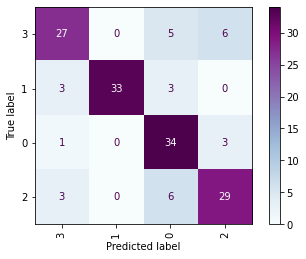

In [ ]:
from sklearn.svm import LinearSVC

svm = LinearSVC(class_weight='balanced', verbose=False, max_iter=10000, tol=1e-4, C=0.1)
print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, accuracy, metrics_report, svm_prf = train_test_model(svm, X_train, X_test, y_train, y_test, labels)
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('accuracy: {}'.format(accuracy))
print('='*100)
print(metrics_report)
plot_confusion_matrix(svm, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

# Random Forest

Number of documents = 611  |  Number of features = 1014
Start training...done!
Start testing...done!
Total time: 0.67s
accuracy: 0.7908496732026143
              precision    recall  f1-score   support

           3       0.68      0.84      0.75        38
           1       0.97      0.85      0.90        39
           0       0.75      0.87      0.80        38
           2       0.82      0.61      0.70        38

    accuracy                           0.79       153
   macro avg       0.81      0.79      0.79       153
weighted avg       0.81      0.79      0.79       153



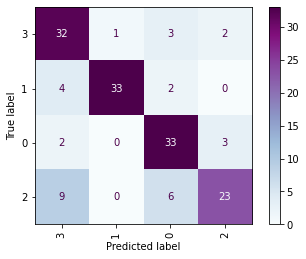

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=100, min_samples_split=10, n_jobs=-1, verbose=0)
print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, accuracy, metrics_report, rf_prf = train_test_model(rf_model, X_train, X_test, y_train, y_test, labels)
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('accuracy: {}'.format(accuracy))
print('='*100)
print(metrics_report)
plot_confusion_matrix(rf_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

# Gradient Boosting

Start training...done!
Start testing...done!
accuracy: 0.7712418300653595
              precision    recall  f1-score   support

           3       0.68      0.79      0.73        38
           1       0.97      0.85      0.90        39
           0       0.74      0.74      0.74        38
           2       0.73      0.71      0.72        38

    accuracy                           0.77       153
   macro avg       0.78      0.77      0.77       153
weighted avg       0.78      0.77      0.77       153



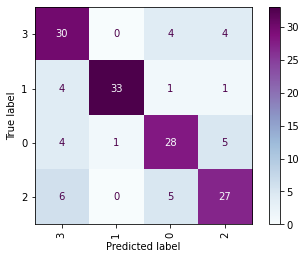

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier


gb_model = GradientBoostingClassifier(n_estimators=50, max_depth=10)
predictions, accuracy, metrics_report, gb_prf = train_test_model(gb_model, X_train, X_test, y_train, y_test, labels)
print('accuracy: {}'.format(accuracy))
print(metrics_report)
plot_confusion_matrix(gb_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

# Sammary

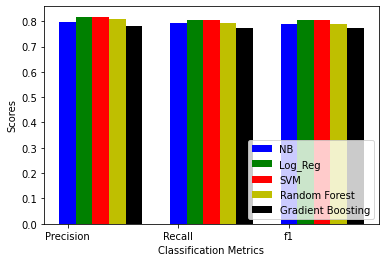

In [ ]:
xx = np.array([1,2,3])
width = 0.15
ax = plt.subplot(111)
ax.bar( xx - width, height=np.array(nb_prf), width=width, color='b', align='center', label='NB', tick_label=['Precision', 'Recall', 'f1'])
ax.bar(xx ,height=np.array(log_prf), width=width, color='g', align='center', label='Log_Reg')
ax.bar(xx + width, height=np.array(svm_prf), width=width, color='r', align='center', label='SVM')
ax.bar(xx + 2*width, height=np.array(rf_prf), width=width, color='y', align='center', label='Random Forest')
ax.bar(xx + 3*width, height=np.array(gb_prf), width=width, color='black', align='center', label='Gradient Boosting')


plt.xlabel('Classification Metrics')
plt.ylabel('Scores')
plt.legend(loc='lower right')
plt.show()

# Cross Validation

## Naive Bayes Cross Validation


In [ ]:
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
nb_model = MultinomialNB()

accs = []
reports = []
f1_scores = []
st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    predictions, accuracy, metrics_report, nb_prf_x = train_test_model(nb_model, X_train, X_test, y_train, y_test, labels)
    accs.append(accuracy)
    reports.append(metrics_report)
    
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f}'.format(np.mean(accs)))

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 0.05s
mean accuracy: 0.79


## Logistic Regression Cross Validation

In [ ]:
log_model = LogisticRegression(penalty='l2', max_iter=500)
accs = []
reports = []
st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    predictions, accuracy, metrics_report, log_prf_x = train_test_model(log_model, X_train, X_test, y_train, y_test, labels)
    accs.append(accuracy)
    reports.append(metrics_report)

en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f}'.format(np.mean(accs)))

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 0.45s
mean accuracy: 0.79


## SVM Cross Validation

In [ ]:
svm = LinearSVC(class_weight='balanced', verbose=False, max_iter=10000, tol=1e-4, C=0.1)
accs = []
reports = []
st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    predictions, accuracy, metrics_report, svm_prf_x = train_test_model(svm, X_train, X_test, y_train, y_test, labels)
    accs.append(accuracy)
    reports.append(metrics_report)

en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time)) 
print('mean accuracy: {:.2f}'.format(np.mean(accs)))

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 0.06s
mean accuracy: 0.79


## Random Forest Cross Validation

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=100, min_samples_split=10, n_jobs=-1, verbose=0)
accs = []
reports = []
st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    predictions, accuracy, metrics_report, rf_prf_x = train_test_model(rf_model, X_train, X_test, y_train, y_test, labels)
    accs.append(accuracy)
    reports.append(metrics_report)

en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time)) 
print('mean accuracy: {:.2f}'.format(np.mean(accs)))

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 2.83s
mean accuracy: 0.75


## Gradient Boosting  Cross Validation


In [ ]:
gb_model = GradientBoostingClassifier(n_estimators=50, max_depth=10)
accs = []
reports = []
st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    predictions, accuracy, metrics_report, gb_prf_x = train_test_model(rf_model, X_train, X_test, y_train, y_test, labels)
    accs.append(accuracy)
    reports.append(metrics_report)

en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time)) 
print('mean accuracy: {:.2f}'.format(np.mean(accs)))

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 2.84s
mean accuracy: 0.73


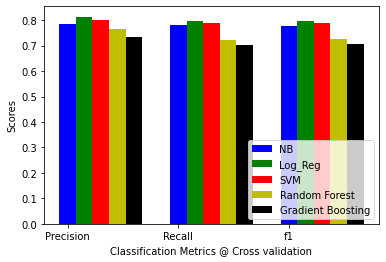

In [ ]:
xx = np.array([1,2,3])
width = 0.15
ax = plt.subplot(111)
ax.bar( xx - width, height=np.array(nb_prf_x), width=width, color='b', align='center', label='NB', tick_label=['Precision', 'Recall', 'f1'])
ax.bar(xx ,height=np.array(log_prf_x), width=width, color='g', align='center', label='Log_Reg')
ax.bar(xx + width, height=np.array(svm_prf_x), width=width, color='r', align='center', label='SVM')
ax.bar(xx + 2*width, height=np.array(rf_prf_x), width=width, color='y', align='center', label='Random Forest')
ax.bar(xx + 3*width, height=np.array(gb_prf_x), width=width, color='black', align='center', label='Gradient Boosting')

plt.xlabel('Classification Metrics @ Cross validation')
plt.ylabel('Scores')
plt.legend(loc='lower right')
plt.show()

# prediction

In [ ]:
from sklearn import preprocessing

predict_text, vectorizer = compute_tfidf(test_df['sentence'], stop_words, ngram_range, max_features=1014)

Computing tfidf features...done!


In [ ]:
predict_text.shape

(28437, 1014)

In [ ]:
pred = log_model.predict(predict_text)
pred

array([0, 3, 3, ..., 0, 0, 0])

In [ ]:
pred.shape

(28437,)

In [ ]:
test_df.shape

(28437, 3)

In [ ]:
pred_x = np.array(pred)

In [ ]:
ans = np.append(test_df, pred_x.reshape(len(pred_x),1), 1)
ans[:, [0, 3]]

array([['pb-09-0000', 0],
       ['pb-09-0001', 3],
       ['pb-09-0002', 3],
       ...,
       ['pb-71-0430', 0],
       ['pb-71-0431', 0],
       ['pb-71-0432', 0]], dtype=object)

In [ ]:
ans

array([['pb-09-0000', 'PART\xa0I', 'Form10k_09', 0],
       ['pb-09-0001',
        'In this Annual Report on Form 10-K, unless otherwise mentioned, the terms the “Company”, “we”, “us” and “our” refer to Dime Community Bancshares, Inc. and our wholly-owned subsidiary, Dime Community Bank (the “Bank”).',
        'Form10k_09', 3],
       ['pb-09-0002',
        'We use the term “Holding Company” to refer solely to Dime Community Bancshares, Inc. and not to our consolidated subsidiary.',
        'Form10k_09', 3],
       ...,
       ['pb-71-0430', 'Item 15.', 'Form10k_71', 0],
       ['pb-71-0431', 'Exhibits', 'Form10k_71', 0],
       ['pb-71-0432',
        'The following exhibits are includedas part of this report by reference:',
        'Form10k_71', 0]], dtype=object)

In [ ]:
df_f = pd.DataFrame(ans[:, [0, 3]])
df_f.head()

,0,1
0,pb-09-0000,0
1,pb-09-0001,3
2,pb-09-0002,3
3,pb-09-0003,0
4,pb-09-0004,0


In [ ]:
df_f.to_csv(f'/content/drive/MyDrive/data/output2.tsv', header = False, index=False, sep='\t')

0.0435300

Logistic Regression 0.0477752

# XGBOOST

In [ ]:
import xgboost as xgb

xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_test = xgb.DMatrix(X_test, label=y_test)

# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
param['eta'] = 0.05
param['max_depth'] = 12
param['nthread'] = 4
param['num_class'] = 7
param['gpu_id'] = 0

watchlist = [(xgb_train, 'train'), (xgb_test, 'test')]
num_round = 5
bst = xgb.train(param, xgb_train, num_round)

bst = xgb.train(param, xgb_train, num_round, watchlist)
# get prediction
pred = bst.predict(xgb_test)
error_rate = np.sum(pred != y_test) / y_test.shape[0]
print('Test error using softmax = {}'.format(error_rate))


[0]	train-merror:0.21732	test-merror:0.407895
[1]	train-merror:0.202614	test-merror:0.388158
[2]	train-merror:0.189542	test-merror:0.407895
[3]	train-merror:0.19281	test-merror:0.407895
[4]	train-merror:0.184641	test-merror:0.394737
Test error using softmax = 0.39473684210526316


In [ ]:
pred

array([3., 1., 3., 0., 0., 0., 0., 0., 1., 2., 2., 0., 1., 2., 0., 0., 1.,
       0., 0., 1., 2., 3., 2., 0., 0., 2., 1., 0., 1., 1., 0., 0., 0., 2.,
       1., 0., 2., 2., 0., 0., 1., 0., 3., 0., 1., 3., 3., 1., 0., 3., 2.,
       2., 2., 1., 3., 3., 0., 2., 2., 0., 1., 3., 3., 3., 2., 1., 2., 2.,
       3., 3., 0., 0., 2., 3., 0., 0., 0., 0., 1., 0., 3., 1., 0., 2., 2.,
       3., 0., 2., 1., 2., 2., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0.,
       2., 0., 0., 3., 3., 3., 0., 0., 3., 0., 3., 1., 1., 0., 0., 0., 0.,
       1., 3., 0., 0., 1., 3., 3., 0., 2., 2., 2., 1., 0., 2., 1., 3., 1.,
       3., 1., 0., 0., 1., 0., 0., 3., 2., 0., 3., 2., 0., 1., 1., 0.],
      dtype=float32)

In [ ]:
xgb_pred = xgb.DMatrix(predict_text)

pred3 = bst.predict(xgb_pred)
pred3

array([0., 3., 3., ..., 0., 0., 0.], dtype=float32)

In [ ]:
pred3_x = np.array(pred3)
ans3 = np.append(test_df, pred3_x.reshape(len(pred3_x),1), 1)
ans3[:, [0, 3]]
df_f3 = pd.DataFrame(ans3[:, [0, 3]])
df_f3.head()

df_f3.to_csv(f'/content/drive/MyDrive/data/output3.tsv', header = False, index=False, sep='\t')